In [1]:
import numpy as np

In [2]:
from tqdm import tqdm

In [3]:
def relu(x):
    return np.where(x >= 0, 
                        x, 
                        0)

In [4]:
def get_activation(activation):#maybe getderivatives here iteself ?
    def sigmoid(x):
        return np.where(x >= 0, 
                        1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))
    def softmax(x):
        z=x-np.max(x,axis=0)
        return np.exp(z)/np.sum(np.exp(z),axis=0)
    def relu(x):
        return np.where(x >= 0, 
                            x, 
                            0)
    if activation=='sigmoid':
        return sigmoid
    elif activation=='softmax':
        return softmax
    elif activation== 'tanh':
        return np.tanh
    elif activation== 'relu':
        relu

In [5]:
def get_activation_derivative(activation):#maybe getderivatives here iteself ?
    def sigmoid_d(x):
        sig= np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
        return sig*(1-sig)
    def softmax_d(x):
        z=x-np.max(x,axis=0)
        soft=np.exp(z)/np.sum(np.exp(z),axis=0)
        return soft*(1-soft)
    def tanh_d(x):
        return 1-np.tanh(x)**2
    def relu_d(x):
        return np.where(x >= 0, 
                            x, 
                            0)
    
    if activation=='sigmoid':
        return sigmoid_d
    elif activation=='softmax':
        '''
        need to think more, not required for backprop as we look directly at dL/da_l
        But still, for the sake of completeness, and if user wants softmax in the middle?
        d S(x_i) /d x_j= S(x_i)*(kronecker delta_i,j -S(x_j))
        But we care about only dh_k,j/da_k,j So no need to implement d S(x_i) /d x_j
        d S(x_i) /d x_i should suffice
        so we get array of [ d S(x_1) /d x_1, d S(x_2) /d x_2, ....]
        
        For MSE loss after softmax, we need cross terms...
        '''
        
        return softmax_d
    elif activation=='tanh':
        return tanh_d
    elif activation=='relu':
        return relu_d
    assert(activation=='relu'or activation=='tanh'or activation=='sigmoid' or activation=='softmax'), 'Must be \'relu\'or \'tanh\' or \'sigmoid\' or \'softmax\' '


In [6]:
def get_loss(loss='cross-entropy'):
    
   
    
        
    def crossentropy(P,Q):
        assert(P.shape==Q.shape), "Inputs must be of same shape"

        return np.sum([-np.dot(P[:,i],np.log2(Q[:,i])) for i in range(P.shape[1])])
    def SE(P,Q):
        assert(P.shape==Q.shape), "Inputs must be of same shape"

        return np.sum(np.square(P-Q))
    
    if loss=="SE":
        return SE
    return crossentropy
    
    
      
    
    
    
    

In [7]:
def get_loss_derivative(loss):
    def SE_d(y_in,y_pred_in):
        '''
        derivative of MSE after softmax is used to get probabs from a_L:
        We need indicator because the all terms of y_true are required unlike cross-entropy where only y_pred[l] is required
        Thus transforming the stacked indicator to y_true, not here...
        
        '''

        def indicator(i,j):
                if i==j:
                    return 1
                return 0


        assert(y_in.shape[0]==y_pred_in.shape[0]),"Inputs must contain same number of examples"

        y=y_in.ravel()
        y_pred=y_pred_in.ravel()


        return np.array([
            [2*np.sum([(y_pred[i]-y[i])*y[i]*(indicator(i,j) - y_pred[j]) for i in range(y.shape[0])])]
            for j in range(len(y))
        ])    
   
    
        
    def crossentropy_d(y,y_pred):
        

        return -(y-y_pred)
    
    
    if loss=="cross-entropy":
        return crossentropy_d
    return SE_d
    

In [8]:
class layer:
    def __init__(self,input_size,output_size,activation='sigmoid',type_='random'):
            
        ''' 
        output size number of neurons i
        input size j
        
        '''
        assert(type_=='random'or type_=='xavier'or type=='glorot' or type=='He' ), 'Must be \'random\'or \'xavier\' or \'glorot\' or \'He\' '
        
        if type_=='random':
            scale=0.01
            self.W=np.random.randn(output_size,input_size)*scale #size ixj
            self.b=np.random.randn(output_size,1) *1e-5          #size i
            
        elif type_=='xavier' or type_=='glorot':
            # Xavier Uniform
            r=np.sqrt(6/(input_size+output_size))
            self.W=np.random.uniform(-r,r,(output_size,input_size))
            self.b=np.random.randn(output_size,1) *1e-5
            
        else:#He
            self.W= np.random.randn(output_size,input_size)*np.sqrt(2/input_size)
            self.b=np.random.randn(output_size,1) *1e-5
            
                
            
            
            
        self.a=np.zeros((output_size,1))          #size i
        self.h=np.zeros((output_size,1))         #size i
        self.g=get_activation(activation)
        
        self.d_a=np.zeros((output_size,1))
        self.d_h=np.zeros((output_size,1))
        self.d_W=np.zeros((output_size,input_size))
        self.d_b=np.zeros((output_size,1))
        self.d_g=get_activation_derivative(activation)
        
        
        
    def forward(self, inputs):
        self.a=self.b+np.matmul(self.W,inputs)
        self.h=self.g(self.a)
        return self.h
    def reset(self):
        self.d_a=np.zeros(np.shape(self.d_a))
        self.d_h=np.zeros(np.shape(self.d_h))
        self.d_W=np.zeros(np.shape(self.d_W))
        self.d_b=np.zeros(np.shape(self.d_b))
        
    def hard_set(self,W,b):#hardsets the weight. useful for debugging
        self.W=W
        self.b=b
        


In [9]:
class Model:
    def __init__(self,X_size,Y_size,hidden_layer_sizes=[4],hidden_layer_activations=['sigmoid'],loss='cross-entropy',lamdba_m=0):
        '''
        '''   
        
        self.input_size=X_size
        self.output_size=Y_size
        self.hidden_layer_sizes=hidden_layer_sizes
        self.layers=[]
        
        prev_size=self.input_size
    
        for size,activation in zip(hidden_layer_sizes,hidden_layer_activations):
            self.layers.append(layer(prev_size,size,activation))
            prev_size=size
        self.layers.append(layer(size,self.output_size,'softmax'))
        
        self.loss=get_loss(loss)#without regularization term
        self.loss_d=get_loss_derivative(loss)
        self.lamdba_m=lamdba_m #we shall pass lambda/m to this, where m is patch size
        
    def forward(self,x):
        output=x
        # print(output.shape)
        for layer in  self.layers:
            # print('W',layer.W.shape)
            output=layer.forward(output)
            # print(output.shape)   
        return output
    
    def reset(self):
        for layer in  self.layers:
            # resets the dWs
            layer.reset()
    
 
        
    
          
            
    def backward(self,x,y,y_pred):
        # self.layers[-1].d_h is not needed as d_h is used to calculate d_a and self.layers[-1].h is softmax
        self.layers[-1].d_a=self.loss_d(y,y_pred)
            
        
        
        for idx in range(len(self.layers)-1,0,-1): #goes from L->2, for l=1 we do outside
            
            
            #compute gradient wrt parameters
            self.layers[idx].d_W+=np.matmul(self.layers[idx].d_a,np.transpose(self.layers[idx-1].h))+self.lamdba_m*self.layers[idx].W
            self.layers[idx].d_b+=self.layers[idx].d_a
            
            #compute gradient wrt layer below -- will help in next layer iter
            self.layers[idx-1].d_h=np.matmul(np.transpose(self.layers[idx].W),self.layers[idx].d_a)
            
            #compute gradient -- element wise multiplivation, derivative of the activation function of layer idx-1
            self.layers[idx-1].d_a=self.layers[idx-1].d_h*self.layers[idx-1].d_g(self.layers[idx-1].a)
        assert(idx-1==0)
                        
        self.layers[0].d_W+=np.matmul(self.layers[0].d_a,np.transpose(x))+self.lamdba_m*self.layers[0].W
        self.layers[0].d_b+=self.layers[0].d_a
        
        
        
    def predict(self,Xtest):
        preds=[]
        for i in range(Xtest.shape[1]):
            preds.append(self.forward(Xtest[:,[i]]))
        
        ytest_pred=np.hstack(preds)
        return ytest_pred
    
        
        
                    
                
                
            
            
            
        
    
            
            
        
            
            

In [10]:
class optimizers:
    def __init__(self,X_size,Y_size,hidden_layer_sizes=[4],hidden_layer_activations=['sigmoid'],
                 loss='cross-entropy',optimizer='adam',lamdba=0,batch_size=5,epochs=10,eta=1e-3):
        self.batch_size=batch_size
        self.epochs=epochs
        self.train_loss=[]
        self.val_loss=[]
        self.model=Model(X_size,Y_size,hidden_layer_sizes,hidden_layer_activations,loss,lamdba/self.batch_size)
        self.learning_rate=eta/batch_size
        self.optimizer=optimizer

        

    def batch_gradient_descent(self,traindat,testdat,verbose=False):
        
        '''
        Mini-Batch Gradient Descent
        at batchsize=1, behaves like sgd, batchsize=np.shape(X), behaves as gd
        eta is the learning rate
        '''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        

        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                
                #update if the number of points seen==batch size, or if data ends
                if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                    for layer in self.model.layers:
                        layer.W=layer.W-self.learning_rate*layer.d_W
                        layer.b=layer.b-self.learning_rate*layer.d_b
                    self.model.reset() #reset grads before new epoch
            
            #end of epoch
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
            
    def stochastic_gradient_descent(self,traindat,testdat,eta=1e-3,max_iters=10):
        
        
        '''
        stochastic Gradient Descent
        '''
                
        X,Y=traindat
        
        Xval,Yval=testdat

        for t in tqdm(range(self.epochs)):
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                
                #update
                for layer in self.model.layers:
                    layer.W=layer.W-self.learning_rate*layer.d_W
                    layer.b=layer.b-self.learning_rate*layer.d_b
                self.model.reset() #reset grads before new update
                    
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
        
    def Momentum(self,traindat,testdat,beta=0.9):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        u_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        u_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]

        



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                



            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    u_W[i]=beta*u_W[i]+layer.d_W
                    u_b[i]=beta*u_b[i]+layer.d_b
                    layer.W=layer.W-self.learning_rate*u_W[i]
                    layer.b=layer.b-self.learning_rate*u_b[i]
                self.model.reset() #reset grads before new update
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
                


    def rmsprop(self,traindat,testdat,beta=0.9):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        t=0
        epsilon=1e-10



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                


    

            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    v_W[i]=beta*v_W[i]+(1-beta)*layer.d_W**2
                    v_b[i]=beta*v_b[i]+(1-beta)*layer.d_b**2
                    layer.W=layer.W-(self.learning_rate/np.sqrt(v_W[i]+epsilon))*layer.d_W
                    layer.b=layer.b-(self.learning_rate/np.sqrt(v_b[i]+epsilon))*layer.d_b
                self.model.reset() #reset grads before new epoch
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])

            
    def Adam(self,traindat,testdat,beta1=0.9, beta2=0.999):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        epsilon=1e-10



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                


    

            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    #updating momentum, velocity
                    m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                    m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b
                    
                    v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                    v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2
                    
                    m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                    m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                    v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                    v_b_hat=v_b[i]/(1-np.power(beta2,t+1))
                    
                    
                    
                    layer.W=layer.W-(self.learning_rate*m_W_hat)/(np.sqrt(v_W_hat)+epsilon)
                    layer.b=layer.b-(self.learning_rate*m_b_hat)/(np.sqrt(v_b_hat)+epsilon)
                self.model.reset() #reset grads before new epoch
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
    
    def NAG(self,traindat,testdat,beta=0.9):
        
        ''''''
        
        X,Y=traindat
        
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]

        



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                



            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    m_W[i]=beta*m_W[i]+self.learning_rate*layer.d_W
                    m_b[i]=beta*m_b[i]+self.learning_rate*layer.d_b

                    
                    layer.W=layer.W-(beta*m_W[i]+self.learning_rate*layer.d_W[i])
                    layer.b=layer.b-(beta*m_b[i]+self.learning_rate*layer.d_b[i])
                self.model.reset() #reset grads before new epoch
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
    
    def NAdam(self,traindat,testdat,beta1=0.9, beta2=0.999):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        epsilon=1e-10



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                


    

            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    #updating momentum, velocity
                    m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                    m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b
                    
                    v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                    v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2
                    
                    m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                    m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                    v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                    v_b_hat=v_b[i]/(1-np.power(beta2,t+1))
                    
                    
                    
                    layer.W=layer.W-(self.learning_rate/(np.sqrt(v_W_hat)+epsilon))*\
                    (beta1*m_W_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_W)
                    layer.b=layer.b-(self.learning_rate/(np.sqrt(v_b_hat)+epsilon))*\
                    (beta1*m_b_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_b)
                    
                self.model.reset() #reset grads before new epoch
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])

                
        
            



        

        
    

In [47]:
class optimizers_beta:
    def __init__(self,X_size,Y_size,hidden_layer_sizes=[4],hidden_layer_activations=['sigmoid'],
                 loss='cross-entropy',optimizer='adam',lamdba=0,batch_size=5,epochs=10,eta=1e-3):
        self.batch_size=batch_size
        self.epochs=epochs
        self.train_loss=[]
        self.val_loss=[]
        self.model=Model(X_size,Y_size,hidden_layer_sizes,hidden_layer_activations,loss,lamdba/self.batch_size)
        self.learning_rate=eta
        self.optimizer=optimizer

        

    def batch_gradient_descent(self,traindat,testdat,verbose=False):
        
        '''
        Mini-Batch Gradient Descent
        at batchsize=1, behaves like sgd, batchsize=np.shape(X), behaves as gd
        eta is the learning rate
        '''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        

        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                
                #update if the number of points seen==batch size, or if data ends
                if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                    for layer in self.model.layers:
                        layer.W=layer.W-self.learning_rate*layer.d_W
                        layer.b=layer.b-self.learning_rate*layer.d_b
                    self.model.reset() #reset grads before new epoch
            
            #end of epoch
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
            
    def stochastic_gradient_descent(self,traindat,testdat,eta=1e-3,max_iters=10):
        
        
        '''
        stochastic Gradient Descent
        '''
                
        X,Y=traindat
        
        Xval,Yval=testdat

        for t in tqdm(range(self.epochs)):
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                
                #update
                for layer in self.model.layers:
                    layer.W=layer.W-self.learning_rate*layer.d_W
                    layer.b=layer.b-self.learning_rate*layer.d_b
                self.model.reset() #reset grads before new update
                    
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
        
    def Momentum(self,traindat,testdat,beta=0.9):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        u_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        u_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]

        



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                



            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    u_W[i]=beta*u_W[i]+layer.d_W
                    u_b[i]=beta*u_b[i]+layer.d_b
                    layer.W=layer.W-self.learning_rate*u_W[i]
                    layer.b=layer.b-self.learning_rate*u_b[i]
                self.model.reset() #reset grads before new update
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
                


    def rmsprop(self,traindat,testdat,beta=0.9):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        t=0
        epsilon=1e-10



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                


    

            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    v_W[i]=beta*v_W[i]+(1-beta)*layer.d_W**2
                    v_b[i]=beta*v_b[i]+(1-beta)*layer.d_b**2
                    layer.W=layer.W-(self.learning_rate/np.sqrt(v_W[i]+epsilon))*layer.d_W
                    layer.b=layer.b-(self.learning_rate/np.sqrt(v_b[i]+epsilon))*layer.d_b
                self.model.reset() #reset grads before new epoch
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])

            
    def Adam(self,traindat,testdat,beta1=0.9, beta2=0.999):
        ''''''
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        epsilon=1e-10



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                


    

            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    #updating momentum, velocity
                    m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                    m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b
                    
                    v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                    v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2
                    
                    m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                    m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                    v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                    v_b_hat=v_b[i]/(1-np.power(beta2,t+1))
                    
                    
                    
                    layer.W=layer.W-(self.learning_rate*m_W_hat)/(np.sqrt(v_W_hat)+epsilon)
                    layer.b=layer.b-(self.learning_rate*m_b_hat)/(np.sqrt(v_b_hat)+epsilon)
                self.model.reset() #reset grads before new epoch
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
    
    def NAG(self,traindat,testdat,beta=0.9):
        
        ''''''
        
        X,Y=traindat
        
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]

        



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                



            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    m_W[i]=beta*m_W[i]+self.learning_rate*layer.d_W
                    m_b[i]=beta*m_b[i]+self.learning_rate*layer.d_b

                    
                    layer.W=layer.W-(beta*m_W[i]+self.learning_rate*layer.d_W[i])
                    layer.b=layer.b-(beta*m_b[i]+self.learning_rate*layer.d_b[i])
                self.model.reset() #reset grads before new epoch
                
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])
    
    def NAdam(self,traindat,testdat,beta1=0.9, beta2=0.999):
        ''''''
        
        X,Y=traindat
        
        Xval,Yval=testdat
        
        m_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        v_W=[np.zeros(np.shape(layer.d_W)) for layer in self.model.layers]
        m_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        v_b=[np.zeros(np.shape(layer.d_b)) for layer in self.model.layers]
        
        epsilon=1e-10



        for t in tqdm(range(self.epochs)):
            number_points_seen=0
            for i in range(np.shape(X)[1]):
                x=X[:,[i]]
                y=Y[:,[i]]
                y_pred=self.model.forward(x)
                self.model.backward(x,y,y_pred)
                number_points_seen+=1
                


    

            #update if the number of points seen==batch size, or if data ends
            if number_points_seen%self.batch_size==0 or number_points_seen==np.shape(X)[1]:
                for i in range(len(self.model.layers)):
                    layer=self.model.layers[i]
                    #updating momentum, velocity
                    m_W[i]=beta1*m_W[i]+(1-beta1)*layer.d_W
                    m_b[i]=beta1*m_b[i]+(1-beta1)*layer.d_b
                    
                    v_W[i]=beta2*v_W[i]+(1-beta2)*layer.d_W**2
                    v_b[i]=beta2*v_b[i]+(1-beta2)*layer.d_b**2
                    
                    m_W_hat=m_W[i]/(1-np.power(beta1,t+1))
                    m_b_hat=m_b[i]/(1-np.power(beta1,t+1))
                    v_W_hat=v_W[i]/(1-np.power(beta2,t+1))
                    v_b_hat=v_b[i]/(1-np.power(beta2,t+1))
                    
                    
                    
                    layer.W=layer.W-(self.learning_rate/(np.sqrt(v_W_hat)+epsilon))*\
                    (beta1*m_W_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_W)
                    layer.b=layer.b-(self.learning_rate/(np.sqrt(v_b_hat)+epsilon))*\
                    (beta1*m_b_hat+((1-beta1)/(1-np.power(beta1,t+1)))*layer.d_b)
                    
                self.model.reset() #reset grads before new epoch
            regularization=1/2*self.model.lamdba_m*np.sum([np.sum(layer.W**2) for layer in self.model.layers])
            self.train_loss.append((self.model.loss(Y,self.model.predict(X))+regularization)/X.shape[1])
            self.val_loss.append(self.model.loss(Yval,self.model.predict(Xval))/Xval.shape[1])

                
        
            



        

        
    

In [11]:
ce=get_loss('')

In [12]:
ce

<function __main__.get_loss.<locals>.crossentropy(P, Q)>

# Import Dataset

In [13]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


# np.random.seed(42)#sets a seed, used for reproducability

def one_hot(inarray): #converts to one hot encoding
    outarray = np.zeros((inarray.size, inarray.max() + 1))
    outarray[np.arange(inarray.size), inarray] = 1
    return outarray

def Preprocess(X,y):
      
    '''Unrolls X,y, rehsapes into column vectors, one hots y'''
    assert(X.shape[0]==y.shape[0]),"Inputs must contain same number of examples, stored in rows" #checks if same dim
    X_processed=[]
    y_processed=[]
    
    X_processed=np.reshape(X,(784,X.shape[0]))/255
    y_processed=one_hot(y).T
    return np.array(X_processed),y_processed
        
    



Xtest,ytest=Preprocess(X_test,y_test)

# def tran_val_split(X,y,split=0.1):
#     assert(X.shape[1]==y.shape[1]), "Inputs must contain same number of examples, stored in columns"# as vectors are now stored in cols, do check if no of elemnts are equal
#     len_split=int(np.shape(X)[1]*split)
#     X_val=X[:,:len_split]
#     y_val=y[:,:len_split]
    
#     X_train=X[:,len_split:]
#     y_train=y[:,len_split:]
    
#     return (X_train,y_train),(X_val,y_val)
    
        

# (Xtrain,ytrain),(Xval,yval)=tran_val_split(X_train_clean,y_train_clean)
from sklearn.model_selection import train_test_split

Xtrain,Xval,ytrain,yval=train_test_split(X_train,y_train,test_size=0.1)
Xtrain,ytrain=Preprocess(Xtrain,ytrain)
Xval,yval=Preprocess(Xval,yval)

2023-03-15 18:11:24.149749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 18:11:24.221657: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 18:11:24.238129: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-15 18:11:24.489256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [15]:
import matplotlib.pyplot as plt

In [16]:
def accuracy_check(Y,Ypred):
    return np.sum(np.argmax(Ypred,axis=0)==np.argmax(Y,axis=0))/Y.shape[1]
    
    
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.38s/it]


94.45083152961693 93.13069968474672
Accuracy train 0.10012962962962962
Accuracy val 0.09883333333333333


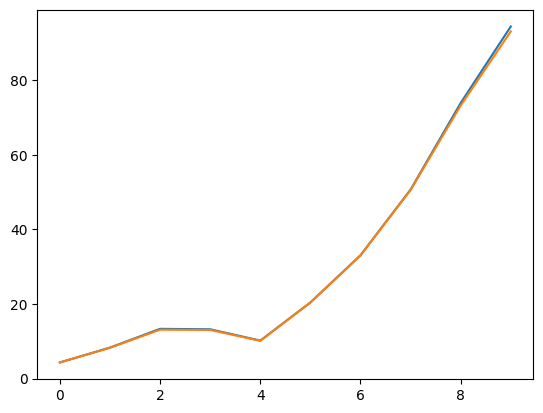

In [18]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=1,epochs=10,eta=1e-3)
opt.Momentum((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-5)
opt.Momentum((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

 10%|█████████████████▎                                                                                                                                                           | 1/10 [00:07<01:08,  7.57s/it]

In [55]:
opt.train_loss[0]

3.3220436478472783

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.62s/it]


3.3219233381117323 3.322441767498379
Accuracy train 0.10066666666666667
Accuracy val 0.094


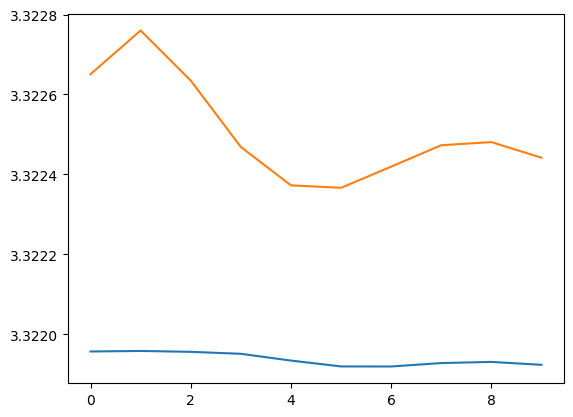

In [50]:
opt=optimizers_beta(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-3)
opt.Adam((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)


print(opt.train_loss[-1],opt.val_loss[-1])
print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.53s/it]


51.63505219394544 51.354856000779236
Accuracy train 0.0997037037037037
Accuracy val 0.10266666666666667


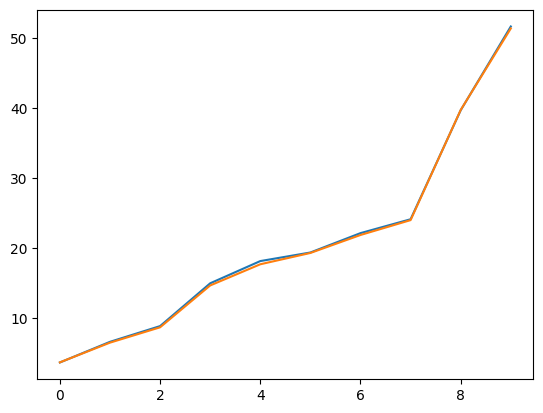

In [51]:
opt=optimizers_beta(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-3)
opt.NAG((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [ ]:
opt=optimizers_beta(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1e-3)
opt.rmsproppropproppropproppropprop((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)




print(opt.train_loss[-1],opt.val_loss[-1])

print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [03:30<00:00, 10.54s/it]


3.3088818968575286 3.329580039638158
Accuracy train 0.12368518518518519
Accuracy val 0.0905


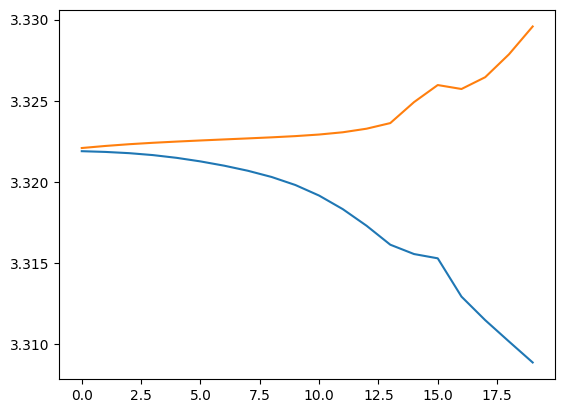

In [45]:
opt=optimizers_beta(Xtrain.shape[0],ytrain.shape[0],[64,64,64],['tanh','tanh','tanh'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=64,epochs=20,eta=1e-3)
opt.NAdam((Xtrain,ytrain),(Xval,yval))
plt.plot(opt.train_loss)
plt.plot(opt.val_loss)


print(opt.train_loss[-1],opt.val_loss[-1])
print('Accuracy train',accuracy_check(opt.model.predict(Xtrain),ytrain))
print('Accuracy val',accuracy_check(opt.model.predict(Xval),yval))

In [119]:
get_activation_derivative('tanh')

In [95]:
ytrain[:,[5]]

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [29]:
opt1=optimizers_beta(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],
           loss='cross-entropy',optimizer='adam',
           lamdba=0,batch_size=32,epochs=10,eta=1)
opt1.Momentum(Xtrain,ytrain)

  0%|                                                                                        | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_263324/3051356264.py:4: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),
/tmp/ipykernel_263324/3051356264.py:5: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_263324/3051356264.py:5: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_263324/2350236407.py:3: RuntimeWarning: overflow encountered in exp
  sig= np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_263324/2350236407.py:3: RuntimeWarning: invalid value encountered in divide
  sig= np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.42s/it]


In [31]:
opt1.model.predict(Xtrain)

/tmp/ipykernel_263324/3051356264.py:4: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),
/tmp/ipykernel_263324/3051356264.py:5: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_263324/3051356264.py:5: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x)))


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
opt.val_loss

[1135698.9042996801,
 722205.8559731487,
 1145458.4628181139,
 661414.9055450959,
 627306.536692417,
 899225.0327810444,
 923356.2524374668,
 897567.758220579,
 872216.2009765874,
 574824.0449465292]

In [18]:
opt.train_loss

[10253020.98328472,
 6501257.507362568,
 10301063.764841832,
 6085232.581547336,
 5665261.55423742,
 8086736.810442188,
 8376521.935310364,
 8102726.43013503,
 7821117.363724159,
 5192653.574056605]

In [139]:
Xtrain.shape

(784, 54000)

In [22]:
opt.model.predict(Xtrain[:,[1
                           ]])

/tmp/ipykernel_263324/3051356264.py:4: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),
/tmp/ipykernel_263324/3051356264.py:5: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_263324/3051356264.py:5: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x)))


array([[5.92825422e-27],
       [6.60474613e-37],
       [1.00000000e+00],
       [3.18132807e-24],
       [1.85506371e-62],
       [1.44970372e-18],
       [7.64890270e-19],
       [8.59918105e-22],
       [6.16937440e-60],
       [3.18209329e-26]])

In [150]:
ytrain[:,[0]]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]])

In [171]:
optl=optimizers(Xtrain.shape[0],ytrain.shape[0],[32,32,32],['sigmoid','sigmoid','sigmoid'],)
optl.batch_gradient_descent(Xtrain,ytrain,max_iters=10,batch_size=32)

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_707411/3051356264.py:4: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),
/tmp/ipykernel_707411/3051356264.py:5: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_707411/3051356264.py:5: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_707411/2350236407.py:3: RuntimeWarning: overflow encountered in exp
  sig= np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_707411/2350236407.py:3: RuntimeWarning: invalid value encountered in divide
  sig= np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:01<00:00,  6.19s/it]


In [173]:
ytrain[:,[0]]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.]])

In [172]:
optl.predict(Xtrain[:,[0]])

/tmp/ipykernel_707411/3051356264.py:4: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),
/tmp/ipykernel_707411/3051356264.py:5: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x)))
/tmp/ipykernel_707411/3051356264.py:5: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x)))


array([[1.00367103e-18],
       [3.54753173e-12],
       [1.02516943e-27],
       [1.57570798e-12],
       [4.54712588e-16],
       [9.99994626e-01],
       [6.52285718e-10],
       [3.88804446e-33],
       [5.37285486e-06],
       [8.80865142e-17]])